## Data Preprocessing

In [1]:
import os
from glob import glob
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid


In [2]:
# check if machine has gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on",device)

Running on cuda:0


In [3]:
# data path that training set is located
path = "../data/fruits/fruits-360/"
# this joins the path + folder and each files e.g. '../data/fruits/fruits-360/Training/Apple Braeburn/115_100.jpg'
files_training = glob(os.path.join(path,'Training', '*/*.jpg'))
num_images = len(files_training)
print('Number of images in Training file:', num_images)

Number of images in Training file: 67692


In [4]:
# just to see how many images we have for each label, minimum one and average one, with nice printing style

min_images = 1000
im_cnt = []
class_names = []
print('{:18s}'.format('class'), end='')
print('Count:')
print('-' * 24)
for folder in os.listdir(os.path.join(path, 'Training')):
    folder_num = len(os.listdir(os.path.join(path,'Training',folder)))
    im_cnt.append(folder_num)
    class_names.append(folder)
    print('{:20s}'.format(folder), end=' ')
    print(folder_num)
        
num_classes = len(class_names)
print("\nMinumum images per category:", np.min(im_cnt), 'Category:', class_names[im_cnt.index(np.min(im_cnt))])    
print('Average number of Images per Category: {:.0f}'.format(np.array(im_cnt).mean()))
print('Total number of classes: {}'.format(num_classes))

class             Count:
------------------------
Apple Braeburn       492
Apple Crimson Snow   444
Apple Golden 1       480
Apple Golden 2       492
Apple Golden 3       481
Apple Granny Smith   492
Apple Pink Lady      456
Apple Red 1          492
Apple Red 2          492
Apple Red 3          429
Apple Red Delicious  490
Apple Red Yellow 1   492
Apple Red Yellow 2   672
Apricot              492
Avocado              427
Avocado ripe         491
Banana               490
Banana Lady Finger   450
Beetroot             450
Blueberry            462
Cactus fruit         490
Cantaloupe 1         492
Cantaloupe 2         492
Carambula            490
Cauliflower          702
Cherry 1             492
Cherry 2             738
Cherry Rainier       738
Cherry Wax Black     492
Cherry Wax Red       492
Cherry Wax Yellow    492
Chestnut             450
Clementine           490
Cocos                490
Corn                 450
Corn Husk            462
Cucumber Ripe 2      468
Dates                490


In [5]:
# Just to guess pop_mean and pop_std

tensor_transform = transforms.Compose([transforms.ToTensor()])

training_data = ImageFolder(os.path.join(path, 'Training'), tensor_transform)

data_loader = torch.utils.data.DataLoader(training_data, batch_size=512, shuffle=True)

In [6]:
%time
# this part takes a bit long
pop_mean = [0.6840367,0.5786325,0.5037564]  # normally it was --> []
pop_std = [0.30334985,0.3599262,0.3913685]

# for i, data in tqdm(enumerate(data_loader, 0)):
#     numpy_image = data[0].numpy()
    
#     batch_mean = np.mean(numpy_image, axis=(0,2,3))
#     batch_std = np.std(numpy_image, axis=(0,2,3))
    
#     pop_mean.append(batch_mean)
#     pop_std.append(batch_std)

# pop_mean = np.array(pop_mean).mean(axis=0)
# pop_std = np.array(pop_std).mean(axis=0)

# that is why I am inserting last values 

print(pop_mean)
print(pop_std)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
[0.6840367, 0.5786325, 0.5037564]
[0.30334985, 0.3599262, 0.3913685]


In [7]:
np.random.seed(123)
shuffle = np.random.permutation(num_images)

In [8]:
# split validation images

split_val = int(num_images * 0.2)
print('Total number of images:', num_images)
print('Number images in validation set:',len(shuffle[:split_val]))
print('Number images in train set:',len(shuffle[split_val:]))

Total number of images: 67692
Number images in validation set: 13538
Number images in train set: 54154


In [9]:
class FruitTrainDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[split_val:]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

class FruitValidDataset(Dataset):
    def __init__(self, files, shuffle, split_val, class_names, transform=transforms.ToTensor()):
        self.shuffle = shuffle
        self.class_names = class_names
        self.split_val = split_val
        self.data = np.array([files[i] for i in shuffle[:split_val]])
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y
    
class FruitTestDataset(Dataset):
    def __init__(self, path, class_names, transform=transforms.ToTensor()):
        self.class_names = class_names
        self.data = np.array(glob(os.path.join(path, '*/*.jpg')))
        self.transform=transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx])
        name = self.data[idx].split('/')[-2]
        y = self.class_names.index(name)
        img = self.transform(img)
            
        return img, y

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'Test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ]),
    'valid': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(pop_mean, pop_std) # These were the mean and standard deviations that we calculated earlier.
    ])
}

train_dataset = FruitTrainDataset(files_training, shuffle, split_val, class_names, data_transforms['train'])
valid_dataset = FruitValidDataset(files_training, shuffle, split_val, class_names, data_transforms['valid'])
test_dataset = FruitTestDataset("../data/fruits/fruits-360/Test", class_names, transform=data_transforms['Test'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [11]:
dataloaders = {'train': train_loader,
              'valid': valid_loader,
              'Test': test_loader}
dataset_sizes = {
    'train': len(train_dataset),
    'valid': len(valid_dataset),
    'Test': len(test_dataset)
}

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = pop_std * inp + pop_mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

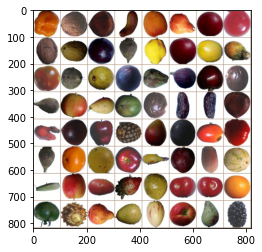

['Pepper Yellow', 'Walnut', 'Chestnut', 'Cucumber Ripe', 'Apricot', 'Pear Red', 'Cherry Wax Red', 'Redcurrant', 'Cocos', 'Papaya', 'Plum 2', 'Beetroot', 'Quince', 'Cherry Wax Red', 'Maracuja', 'Cactus fruit', 'Tomato Maroon', 'Beetroot', 'Guava', 'Plum 3', 'Pear Stone', 'Fig', 'Cherry 1', 'Passion Fruit', 'Beetroot', 'Apple Red 2', 'Pear 2', 'Mango', 'Passion Fruit', 'Dates', 'Dates', 'Chestnut', 'Banana Red', 'Chestnut', 'Apple Red Delicious', 'Pineapple', 'Mango Red', 'Grape Blue', 'Kaki', 'Tomato 3', 'Beetroot', 'Tomato Yellow', 'Grape White 3', 'Apple Red Delicious', 'Banana', 'Plum', 'Hazelnut', 'Cantaloupe 2', 'Corn Husk', 'Apple Pink Lady', 'Potato Red Washed', 'Strawberry', 'Guava', 'Cherry 2', 'Cherry 2', 'Grapefruit Pink', 'Tomato not Ripened', 'Pineapple Mini', 'Pear Red', 'Pear', 'Pepino', 'Apple Crimson Snow', 'Pear Stone', 'Mulberry']


In [13]:
inputs, classes = next(iter(train_loader))
out = make_grid(inputs)

cats = ['' for x in range(len(classes))]
for i in range(len(classes)):
    cats[i] = class_names[classes[i].item()]
    
imshow(out)
print(cats)

In [14]:
# just to check if shape of train and test sets match
for i,j in zip(train_loader,test_loader):
    print(i[0].shape,j[0].shape)
    break

torch.Size([64, 3, 100, 100]) torch.Size([64, 3, 100, 100])


## Network

In [15]:
# just to start from the basic NN and to observe how does it perform on data
# with horizontal and vertical flip we have 3x100x100
# batch size is 64

class Net(nn.Module):
    def __init__(self):
        super().__init__() # initialize the parent class methods
        self.fc1 = nn.Linear(3*100*100, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 131)
        
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x,dim=1)
    
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=30000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=131, bias=True)
)


In [16]:
# move network to GPU
net = Net().to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.7)

In [24]:
# let's train the network
def train(net):
    for epoch in tqdm(range(10)):
        print("epoch {}".format(epoch))
        running_loss = 0.0

        for i,data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs.view(-1,3*100*100))    
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 100 mini-batches
                print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
                
    print('Finished Training')
    
train(net)

epoch 0
[1,   100] loss: 4.763
[1,   200] loss: 4.689
[1,   300] loss: 4.567
[1,   400] loss: 4.439
[1,   500] loss: 4.242
[1,   600] loss: 3.996
[1,   700] loss: 3.676
[1,   800] loss: 3.352
epoch 1
[2,   100] loss: 2.861
[2,   200] loss: 2.611
[2,   300] loss: 2.379
[2,   400] loss: 2.185
[2,   500] loss: 1.996
[2,   600] loss: 1.883
[2,   700] loss: 1.744
[2,   800] loss: 1.619
epoch 2
[3,   100] loss: 1.455
[3,   200] loss: 1.359
[3,   300] loss: 1.255
[3,   400] loss: 1.191
[3,   500] loss: 1.112
[3,   600] loss: 1.054
[3,   700] loss: 0.951
[3,   800] loss: 0.927
epoch 3
[4,   100] loss: 0.837
[4,   200] loss: 0.810
[4,   300] loss: 0.774
[4,   400] loss: 0.742
[4,   500] loss: 0.723
[4,   600] loss: 0.678
[4,   700] loss: 0.643
[4,   800] loss: 0.656
epoch 4
[5,   100] loss: 0.595
[5,   200] loss: 0.599
[5,   300] loss: 0.575
[5,   400] loss: 0.539
[5,   500] loss: 0.540
[5,   600] loss: 0.492
[5,   700] loss: 0.517
[5,   800] loss: 0.465
epoch 5
[6,   100] loss: 0.470
[6,   200

In [25]:
PATH = "../models/fnn_net.pth"
torch.save(net.state_dict(),PATH)

In [26]:
def test(net):

    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images.view(-1,3*100*100))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

test(net)


Accuracy of the network on the test images: 82 %


In [27]:
# label wise accuracy
class_correct = list(0. for i in range(131))
class_total = list(0. for i in range(131))
with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images.view(-1,3*100*100))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(131):
    print('Accuracy of %5s : %2d %%' % (
    class_names[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Apple Braeburn : 87 %
Accuracy of Apple Crimson Snow : 48 %
Accuracy of Apple Golden 1 : 100 %
Accuracy of Apple Golden 2 : 100 %
Accuracy of Apple Golden 3 : 66 %
Accuracy of Apple Granny Smith : 92 %
Accuracy of Apple Pink Lady : 86 %
Accuracy of Apple Red 1 : 17 %
Accuracy of Apple Red 2 : 42 %
Accuracy of Apple Red 3 : 37 %
Accuracy of Apple Red Delicious : 100 %
Accuracy of Apple Red Yellow 1 : 92 %
Accuracy of Apple Red Yellow 2 : 100 %
Accuracy of Apricot : 85 %
Accuracy of Avocado : 94 %
Accuracy of Avocado ripe : 99 %
Accuracy of Banana : 45 %
Accuracy of Banana Lady Finger : 80 %
Accuracy of Beetroot : 45 %
Accuracy of Blueberry : 87 %
Accuracy of Cactus fruit : 89 %
Accuracy of Cantaloupe 1 : 100 %
Accuracy of Cantaloupe 2 : 99 %
Accuracy of Carambula : 35 %
Accuracy of Cauliflower : 98 %
Accuracy of Cherry 1 : 100 %
Accuracy of Cherry 2 : 78 %
Accuracy of Cherry Rainier : 65 %
Accuracy of Cherry Wax Black : 100 %
Accuracy of Cherry Wax Red : 99 %
Accuracy of Ch

* In sample accuracy can be added to train function

* Plots will be done (loss + in_sample_accuracy etc) for model analysis

* This network will be extended (maybe adding new layer or changing other parameters)

* Other architecture (especially CNN and its variants) will be tested